In [2]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp
import pingouin as pg
from IPython import embed as shell

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

# get https://github.com/int-brain-lab/paper-behavior/blob/master/paper_behavior_functions.py
sys.path.insert(1, '/Users/urai/Documents/code/int-brain-lab/paper_behavior')
from paper_behavior_functions import (query_sessions, query_subjects, query_sessions_around_criterion, 
                                      dj2pandas, fit_psychfunc)

In [3]:
## GET WEIGHT AND WATER DATA FOR ALL MICE THAT ARE IN THE BEHAVIORAL STANDARDIZATION PREPRINT
subj = query_subjects()

# average watering and weight per session date
weight_with_date = subj * action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')\

# combine all
b = subj  * avg_weight_date * total_water_date
b = b.proj('subject_nickname', 'subject_birth_date','sex', 'lab_name', 'avg_weight', 'total_water', 'watertype')
df = pd.DataFrame(b.fetch(as_dict=True))

# errors in the database; throw away crazy weights
df = df[~(df['avg_weight'] > 80)] 
df = df[~(df['avg_weight'] < 10)] 

In [4]:
# FOR EACH LAB, WHAT'S THE WEEKEND WATER REGIME?
lab_watermap = {}
for name, group in df.groupby(['lab_name']):
    #print(name)
    #print(group.watertype.unique())
    matching = [s for s in group.watertype if "Citric" in s]
    if not len(matching) == 0:
        lab_watermap.update({name:'CA'})
    else:
        lab_watermap.update({name:'restr'})

df['weekend_water_regime'] = df['lab_name'].map(lab_watermap)
df.weekend_water_regime.unique()

array(['restr', 'CA'], dtype=object)

## weight curves

In [5]:
## ADD INFO ABOUT WATER RESTRICTIONS PER MOUSE
weight_normalized = pd.DataFrame([])
for index, sjdatgr in df.groupby(['subject_nickname']):
    sjdat = sjdatgr.copy() # avoid copy warnings
    
    # add normalized weights (from mean per sj) and days from first weighing
    # sjdat['norm_weight'] = sjdat['avg_weight'] / sjdat['avg_weight'].mean()
    sjdat['days_weight'] = sjdat['session_date'] - sjdat['session_date'].min()
    
    # FOR EACH ANIMAL, ADD THEIR WATER RESTRICTION DATES AND REFERENCE WEIGHT
    subj_q = (subject.Subject & 'subject_nickname="%s"'%index) \
                & ( subject.SubjectLab & 'lab_name="%s"'%sjdat.lab_name.unique().item())
    restrictions = (action.WaterRestriction & subj_q).proj(
        'reference_weight',
        restriction_start_date='DATE(restriction_start_time)', 
        restriction_end_date='DATE(restriction_end_time)')
    restrictions = restrictions.fetch(format='frame').reset_index()
    
    # MAKE A NEW COLUMN THAT INDICATES THE START AND END OF WATER RESTRICTION
    if len(restrictions) > 0:
        
        # TAKE ONLY THE FIRST WATER RESTRICTION
        if len(restrictions) > 1:
            restrictions = restrictions.sort_values(by=['restriction_start_date']).head(n=1)
            
        if any(restrictions.restriction_end_date.isnull()):
            # print(subj_q.fetch1('subject_nickname'))
            #restrictions.restriction_end_date[0] = datetime.strptime('23032020', "%d%m%Y").date()
            print('%s''s first WR has no end date'%subj_q.fetch1('subject_nickname'))
          
        else:
            
            # ensure we add a weight on the day that was logged as start of WR
            sjdat = sjdat.append({'subject_uuid':sjdat.subject_uuid.unique().item(),
                          'subject_nickname':sjdat.subject_nickname.unique().item(),
                          'sex':sjdat.sex.unique().item(),
                          'subject_birth_date':sjdat.subject_birth_date.unique().item(),
                          'weekend_water_regime':sjdat.weekend_water_regime.unique().item(),
                          'watertype':'water',
                          'lab_name':sjdat.lab_name.unique().item(),
                          'subject_project':sjdat.subject_project.unique().item(),
                          'session_date':restrictions.restriction_start_date.item(),
                          'avg_weight':restrictions.reference_weight.item()}, ignore_index=True)

            # look at weight curves as a function the animal's reference weight
            sjdat['norm_weight'] = sjdat['avg_weight'] / restrictions.reference_weight.item()

            # new date axis, linearly spaced
            restr_dates_linear = pd.DataFrame(pd.date_range(restrictions.restriction_start_date.item(), 
                                            restrictions.restriction_end_date.item()
                                                        )).reset_index().rename(columns={'index': 'day_restr', 0: 'session_date'})
            # ensure these are the same format before merge
            restr_dates_linear['session_date'] = restr_dates_linear['session_date'].dt.date
            # sjdat['session_date'] = sjdat['session_date'].dt.date
            sjdat = sjdat.merge(restr_dates_linear.set_index('session_date'), on=['session_date'])
            weight_normalized = weight_normalized.append(sjdat)

    else:
        print('%s has no WRs logged'%subj_q.fetch1('subject_nickname'))

# make into a new dataframe
df = weight_normalized.copy()

In [6]:
# compute age range
df['session_age'] = (df.session_date - df.subject_birth_date)

## ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['session_date'] = pd.to_datetime(df.session_date)
df['week_number']  = df['session_date'].dt.week
df['weekday_name'] = df['session_date'].dt.day_name()
#df['days_weight']  = df['days_weight'].dt.days

df.groupby(['days_weight'])['session_age'].describe()

,count,mean,std,min,25%,50%,75%,max
days_weight,,,,,,,,
0 days,136,86 days 09:00:00,13 days 04:00:03.037970,56 days,79 days 00:00:00,85 days,92 days 00:00:00,147 days
1 days,129,86 days 23:04:11.162790,13 days 01:41:19.477221,57 days,80 days 00:00:00,86 days,93 days 00:00:00,148 days
2 days,122,87 days 07:52:07.868852,13 days 03:51:02.730722,58 days,80 days 00:00:00,87 days,92 days 18:00:00,149 days
3 days,86,92 days 13:40:27.906976,12 days 16:12:54.261358,74 days,87 days 00:00:00,91 days,95 days 00:00:00,150 days
4 days,72,92 days 20:00:00,12 days 19:17:49.803833,75 days,88 days 00:00:00,90 days,94 days 12:00:00,151 days
...,...,...,...,...,...,...,...,...
177 days,2,268 days 00:00:00,9 days 21:35:16.362523,261 days,264 days 12:00:00,268 days,271 days 12:00:00,275 days
178 days,1,262 days 00:00:00,NaT,262 days,262 days 00:00:00,262 days,262 days 00:00:00,262 days
179 days,3,269 days 00:00:00,5 days 04:42:27.569321,263 days,267 days 12:00:00,272 days,272 days 00:00:00,272 days


 ## learning curves

In [7]:
b = (behavioral_analyses.BehavioralSummaryByDate * subj)
behav = b.fetch(order_by='subject_nickname, training_day',
                format='frame').reset_index()
behav['weekend_water_regime'] = behav['lab_name'].map(lab_watermap)
behav.n_trials_date = behav.n_trials_date.astype(int) # make sure this can be plotted

# make sure each mouse starts at 0
for index, group in behav.groupby(['lab_name', 'subject_nickname']):
    behav['training_day'][behav.index.isin(
        group.index)] = group['training_day'] - group['training_day'].min()
behav['performance_easy'] = behav.performance_easy * 100

behav.groupby(['weekend_water_regime'])['lab_name', 'subject_nickname'].nunique()

/anaconda3/envs/iblenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/envs/iblenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


,lab_name,subject_nickname
weekend_water_regime,,
CA,4,82
restr,5,58


In [8]:
behav.groupby(['weekend_water_regime', 'lab_name'])['lab_name'].unique()

weekend_water_regime  lab_name      
CA                    angelakilab          [angelakilab]
                      churchlandlab      [churchlandlab]
                      mainenlab              [mainenlab]
                      zadorlab                [zadorlab]
restr                 cortexlab              [cortexlab]
                      danlab                    [danlab]
                      hoferlab                [hoferlab]
                      mrsicflogellab    [mrsicflogellab]
                      wittenlab              [wittenlab]
Name: lab_name, dtype: object

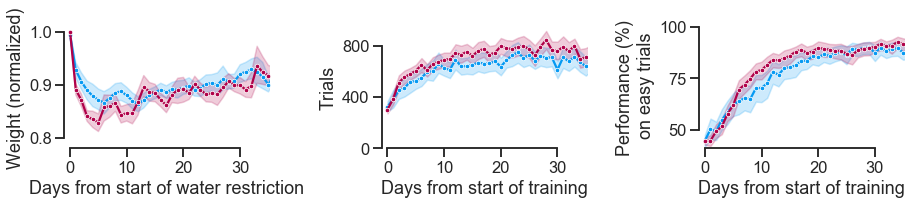

In [9]:
## NOW PLOT
condition_order = [ "restr", "CA"]
palette = sns.xkcd_palette(['azure', 'raspberry'])
f, ax = plt.subplots(ncols=3, nrows=1, figsize=[13, 3])

# 1. weight
sns.lineplot(data=df, x='day_restr', y='norm_weight', hue='weekend_water_regime', 
                 palette=palette, hue_order=condition_order, ax=ax[0], legend=False, 
                err_style='band', marker='.')
#ax[0].axhline(y=1, color='darkgrey', linestyle=':', zorder=-100)
ax[0].set(xlim=[-1, 35.2], xticks=[0, 10, 20, 30], ylim=[0.78, 1.01], yticks=[0.8, 0.9, 1],
          xlabel='Days from start of water restriction', ylabel="Weight (normalized)")

# 2. trials
sns.lineplot(data=behav, x='training_day', y='n_trials_date', hue='weekend_water_regime', 
                 palette=palette, hue_order=condition_order, ax=ax[1], legend=False, 
                err_style='band', marker='.')            
ax[1].set(xlim=ax[0].get_xlim(), xticks=[0, 10, 20, 30], yticks=[0, 400, 800], ylim=[0, 950],
          xlabel='Days from start of training', ylabel="Trials")

# 3. performance
sns.lineplot(data=behav, x='training_day', y='performance_easy', hue='weekend_water_regime', 
                 palette=palette, hue_order=condition_order, ax=ax[2], legend=False, 
                err_style='band', marker='.')    
#ax[2].axhline(y=50, color='darkgrey', linestyle=':', zorder=-100)
ax[2].set(xlim=ax[0].get_xlim(), xticks=[0, 10, 20, 30], ylim=[41, 100], yticks=[50, 75, 100],
          xlabel='Days from start of training', ylabel="Performance (%)\n on easy trials")

#ax[0].set_title('All IBL mice, n = %d (2-9 months)'%behav.subject_uuid.nunique(), fontsize=18, fontstyle='italic')
sns.despine(trim=True)
#f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.tight_layout()
f.savefig(os.path.join(figpath, "ibl_learningcurves.pdf"))

## some data about each animal at training

In [10]:
# HOW MANY DAYS TO TRAINING?
df = subject.Subject.aggr(acquisition.Session * behavioral_analyses.SessionTrainingStatus()
    & 'training_status = "in_training" OR training_status = "untrainable"',
                          days_to_trained='count(distinct(date(session_start_time)))') * subj
df = df.fetch(format='frame').reset_index()
df['weekend_water_regime'] = df['lab_name'].map(lab_watermap)
df.head(n=3)

,subject_uuid,lab_name,subject_project,days_to_trained,subject_nickname,sex,subject_birth_date,institution_short,date_trained,weekend_water_regime
0,00778394-c956-408d-8a6c-ca3b05a611d5,cortexlab,ibl_neuropixel_brainwide_01,24,KS019,F,2019-04-30,UCL,2019-09-19,restr
1,019a22c1-b944-4494-9e38-0e45ae6697bf,mrsicflogellab,ibl_neuropixel_brainwide_01,15,SWC_022,M,2019-06-18,SWC,2019-09-26,restr
2,02120449-9b19-4276-a434-513886c2fb19,wittenlab,ibl_neuropixel_brainwide_01,49,ibl_witten_07,F,2018-11-13,Princeton,2019-05-24,restr


In [17]:
# Query sessions

sessions = query_sessions_around_criterion(criterion='trained', days_from_criterion=[2, 0])[0]
sessions = sessions * subject.Subject * subject.SubjectLab * reference.Lab

# Create dataframe with behavioral metrics of all mice
learned = pd.DataFrame(columns=['mouse', 'lab', 'sex', 'perf_easy', 'n_trials',
                                'threshold', 'bias', 'reaction_time',
                                'lapse_low', 'lapse_high'])

learned = []
for i, nickname in enumerate(np.unique(sessions.fetch('subject_nickname'))):
    if np.mod(i+1, 10) == 0:
        print('Loading data of subject %d of %d' % (i+1, len(
                np.unique(sessions.fetch('subject_nickname')))))

    # Get the trials of the sessions around criterion
    trials = (sessions * behavior.TrialSet.Trial
              & 'subject_nickname = "%s"' % nickname).fetch(format='frame')
    trials = trials.reset_index()

    # Add n-trials per day
    ntrials_perday = trials.groupby('session_uuid').count()['trial_id'].mean()

    # Fit a psychometric function to these trials and get fit results
    fit_df = dj2pandas(trials)
    fit_result = fit_psychfunc(fit_df)

    # Get RT, performance and number of trials
    reaction_time = trials['rt'].median()
    perf_easy = trials['correct_easy'].mean()*100
    ntrials_perday = trials.groupby('session_uuid').count()['trial_id'].mean()

    learned.append({'mouse':nickname,
                    'sex':(sessions & 'subject_nickname = "%s"' % nickname).fetch('sex')[0],
                   'lab_name':(sessions & 'subject_nickname = "%s"' % nickname).fetch('lab_name')[0],
                   'perf_easy':perf_easy,
                   'n_trials':ntrials_perday,
                   'rt':reaction_time,
                   'threshold':fit_result.loc[0, 'threshold'],
                    'bias':fit_result.loc[0, 'bias'],
                    'lapse_low':fit_result.loc[0, 'lapselow'],
                   'lapse_high':fit_result.loc[0, 'lapsehigh']})

learned = pd.DataFrame(learned)

Loading data of subject 10 of 140


/anaconda3/envs/iblenv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Loading data of subject 20 of 140
Loading data of subject 30 of 140
Loading data of subject 40 of 140
Loading data of subject 50 of 140
Loading data of subject 60 of 140
Loading data of subject 70 of 140
Loading data of subject 80 of 140
Loading data of subject 90 of 140
Loading data of subject 100 of 140
Loading data of subject 110 of 140
Loading data of subject 120 of 140
Loading data of subject 130 of 140
Loading data of subject 140 of 140


In [18]:
# Drop mice with faulty RT
learned = learned[learned['rt'].notnull()]

# Convert to float
learned[['perf_easy', 'rt', 'threshold', 'n_trials',
         'bias', 'lapse_low', 'lapse_high']] = learned[['perf_easy', 'rt',
                                                        'threshold', 'n_trials', 'bias',
                                                        'lapse_low', 'lapse_high']].astype(float)
learned['subject_nickname'] = learned.mouse
learned['lapse'] = (learned.lapse_low + learned.lapse_high) / 2 # average lapse
learned['weekend_water_regime'] = learned['lab_name'].map(lab_watermap)

# now merge these two dataframes
df2 = df.merge(learned, on=['subject_nickname', 'weekend_water_regime', 'lab_name'])
df2.columns

Index(['subject_uuid', 'lab_name', 'subject_project', 'days_to_trained',
       'subject_nickname', 'sex_x', 'subject_birth_date', 'institution_short',
       'date_trained', 'weekend_water_regime', 'mouse', 'sex_y', 'perf_easy',
       'n_trials', 'rt', 'threshold', 'bias', 'lapse_low', 'lapse_high',
       'lapse'],
      dtype='object')

days_to_trained
t(101) = -1.47, p = 0.145, Bf10 = 0.491
n_trials
t(104) = 1.33, p = 0.188, Bf10 = 0.410
threshold
t(128) = 0.10, p = 0.919, Bf10 = 0.185
bias
t(116) = 1.05, p = 0.297, Bf10 = 0.304
lapse
t(133) = -1.36, p = 0.175, Bf10 = 0.429
rt
t(128) = -0.03, p = 0.978, Bf10 = 0.184


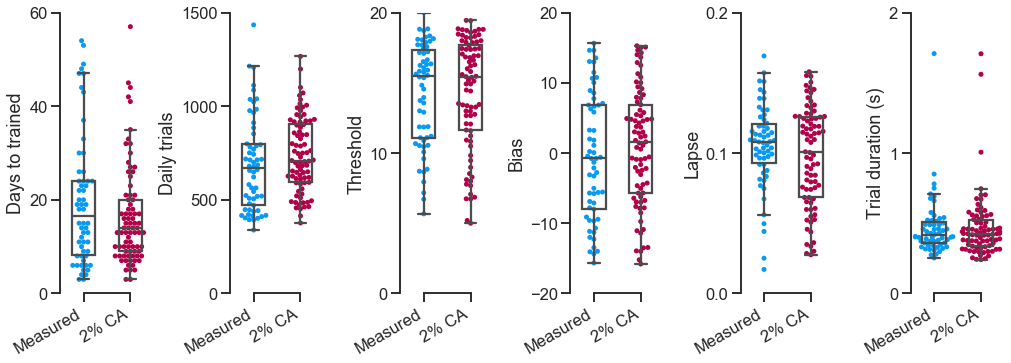

In [21]:
## NOW PLOT ALL OF THESE, ADD STATS ABOVE EACH PANEL
vars = ['days_to_trained','n_trials', 'threshold', 'bias', 'lapse', 'rt']
varnames = ['Days to trained','Daily trials', 'Threshold', 'Bias', 'Lapse', 'Trial duration (s)']

ylims = [[0, 60], [0, 1500], [0, 20], [-20, 20], [0, 0.2], [0, 2]]
yticks = [[0, 20, 40, 60], [0, 500, 1000, 1500], [0, 10, 20], [-20, -10, 0, 10, 20], [0, 0.1, 0.2], [0, 1, 2]]
#markers = ['o', 's', 'v', 'P', '*', 'h', '^', 'H', 'D', 'd', 'P', 'X','p',  '^', '<', '>']

condition_order = [ "restr", "CA"]
palette = sns.xkcd_palette(['azure', 'raspberry'])
f, ax = plt.subplots(ncols=len(vars), nrows=1, figsize=[14, 5])

for vidx, v in enumerate(vars):
    #for lab_name, df3 in df2.groupby(['lab_name']):
    sns.swarmplot(data=df2, x='weekend_water_regime', y=v, ax=ax[vidx],
                  hue='weekend_water_regime', zorder=-100,
                  palette=palette, hue_order=condition_order, marker='o', edgecolor='w')
    sns.boxplot(x="weekend_water_regime", y=v, order=condition_order, 
            data=df2, fliersize=0, boxprops={'facecolor':'None'}, width=.5, ax=ax[vidx],
            zorder=100)
    ax[vidx].get_legend().remove()
    ax[vidx].set(xlabel='', ylim=ylims[vidx], yticks=yticks[vidx], ylabel=varnames[vidx],
                xticklabels=['Measured', '2% CA'])
    for tl in ax[vidx].get_xticklabels():
        tl.set_rotation(30)
        tl.set(ha='right')
    
    ## stats
    ca = df2.loc[df2.weekend_water_regime == 'CA', v]
    re = df2.loc[df2.weekend_water_regime == 'restr', v]
    p = pg.ttest(ca.values.astype(float), re.values.astype(float), paired=False)
    #statistic, pval = sp.stats.ttest_ind(re, ca)
    stat_txt = ('t(%d) = %.2f, p = %.3f, Bf10 = %.3f'%(p.dof.item(),
                                                                 p['T'].item(), 
                                                                 p['p-val'].item(),
                                                                 float(p['BF10'].item())))

    print(v)
    print(stat_txt)
    #print('weekend CA vs week CA: mean %d vs %d, t(%d) = %.3f, p = %.4f'%(np.mean(ca), np.mean(cc), len(ca)-1, statistic, pval))
    #pg.ttest(ca.values, re.values, paired=False)
    pg.tost(ca.values.astype(float), re.values.astype(float), paired=False, correction='auto')
    
f.tight_layout(pad=0.3)
sns.despine(trim=True)
f.savefig(os.path.join(figpath, "ibl_comparison.pdf"))


# IS THERE AN EFFECT OF MOUSE SEX?

In [ ]:
## NOW PLOT ALL OF THESE, ADD STATS ABOVE EACH PANEL
vars = ['days_to_trained','n_trials', 'threshold', 'bias', 'lapse', 'rt']
varnames = ['Days to trained','Daily trials', 'Threshold', 'Bias', 'Lapse', 'Trial duration (s)']

ylims = [[0, 60], [0, 1500], [0, 20], [-20, 20], [0, 0.2], [0, 2]]
yticks = [[0, 20, 40, 60], [0, 500, 1000, 1500], [0, 10, 20], [-20, -10, 0, 10, 20], [0, 0.1, 0.2], [0, 1, 2]]
#markers = ['o', 's', 'v', 'P', '*', 'h', '^', 'H', 'D', 'd', 'P', 'X','p',  '^', '<', '>']

condition_order = [ "restr", "CA"]
palette = sns.xkcd_palette(['azure', 'raspberry'])
f, ax = plt.subplots(ncols=len(vars), nrows=1, figsize=[15, 5])

for vidx, v in enumerate(vars):
    #for lab_name, df3 in df2.groupby(['lab_name']):
    sns.swarmplot(data=df2, x='weekend_water_regime', y=v, ax=ax[vidx],
                  hue='weekend_water_regime', zorder=-100,
                  palette=palette, hue_order=condition_order, marker='o', edgecolor='w')
    sns.boxplot(x="weekend_water_regime", y=v, order=condition_order, 
            data=df2, fliersize=0, boxprops={'facecolor':'None'}, width=.5, ax=ax[vidx],
            zorder=100)
    ax[vidx].get_legend().remove()
    ax[vidx].set(xlabel='', ylim=ylims[vidx], yticks=yticks[vidx], ylabel=varnames[vidx],
                xticklabels=['Measured', '2% CA'])
    for tl in ax[vidx].get_xticklabels():
        tl.set_rotation(30)
        tl.set(ha='right')
    
    ## stats
    ca = df2.loc[df2.weekend_water_regime == 'CA', v]
    re = df2.loc[df2.weekend_water_regime == 'restr', v]
    p = pg.ttest(ca.values.astype(float), re.values.astype(float), paired=False)
    #statistic, pval = sp.stats.ttest_ind(re, ca)
    stat_txt = ('t(%d) = %.2f, p = %.3f, Bf10 = %.3f'%(p.dof.item(),
                                                                 p['T'].item(), 
                                                                 p['p-val'].item(),
                                                                 float(p['BF10'].item())))

    print(v)
    print(stat_txt)
    #print('weekend CA vs week CA: mean %d vs %d, t(%d) = %.3f, p = %.4f'%(np.mean(ca), np.mean(cc), len(ca)-1, statistic, pval))
    #pg.ttest(ca.values, re.values, paired=False)
    pg.tost(ca.values.astype(float), re.values.astype(float), paired=False, correction='auto')
    
f.tight_layout(pad=0.3)
sns.despine(trim=True)
f.savefig(os.path.join(figpath, "ibl_comparison.pdf"))